# Comparación demanda pronosticada, demanda real, y temperatura

In [1]:
# Librerias
from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

from sklearn.linear_model import RidgeCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from pathlib import Path
import datetime as dt
import os

from google.cloud import bigquery
from google.oauth2 import service_account

import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox


In [2]:
# Fecha
FechaRef=dt.date(2026, 2, 8)
FechaFin = FechaRef - dt.timedelta(days=5)
FechaIni= FechaFin - dt.timedelta(days=30)

## Descarga de datos de temperatura

In [3]:
import datetime as dt
from collections import OrderedDict

def build_year_month_days(fecha_ini: dt.date, fecha_fin: dt.date):
    """
    Devuelve un OrderedDict con llaves (year, month) y valores:
    - year: "YYYY"
    - month: "MM"
    - days: ["DD", ...]  (solo los días dentro [fecha_ini, fecha_fin])
    """
    if fecha_ini > fecha_fin:
        raise ValueError("fecha_ini no puede ser mayor que fecha_fin")

    ym_days = OrderedDict()
    d = fecha_ini
    one_day = dt.timedelta(days=1)

    while d <= fecha_fin:
        key = (d.year, d.month)
        if key not in ym_days:
            ym_days[key] = {
                "year": f"{d.year}",
                "month": f"{d.month:02d}",
                "day": []
            }
        ym_days[key]["day"].append(f"{d.day:02d}")
        d += one_day

    return ym_days

resultado_por_mes = build_year_month_days(FechaIni, FechaFin)

# (Opcional) visualizar
for (y, m), payload in resultado_por_mes.items():
    print(payload["year"], payload["month"], payload["day"][0], "...", payload["day"][-1], "n_dias=", len(payload["day"]))



2026 01 04 ... 31 n_dias= 28
2026 02 01 ... 03 n_dias= 3


In [4]:
lista_years = sorted({payload["year"] for payload in resultado_por_mes.values()})

lista_months = sorted({payload["month"] for payload in resultado_por_mes.values()})

lista_days = sorted({d for payload in resultado_por_mes.values() for d in payload["day"]})



In [5]:
lista_days

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31']

In [6]:
import cdsapi 
dataset = "reanalysis-era5-single-levels" 
request = { "product_type": ["reanalysis"], 
           "variable": [ "2m_dewpoint_temperature", "2m_temperature" ], 
           "year": lista_years, 
           "month": lista_months, 
           "day": lista_days, 
           "time": [ "00:00", "01:00", "02:00", "03:00", "04:00", "05:00", "06:00", "07:00", "08:00", "09:00", "10:00", "11:00", "12:00", 
                    "13:00", "14:00", "15:00", "16:00", "17:00", "18:00", "19:00", "20:00", "21:00", "22:00", "23:00" ], 
           "data_format": "netcdf", 
           "download_format": "unarchived", 
           "area": [13.5, -78, 8, -71] }
 
client = cdsapi.Client() 
client.retrieve(dataset, request, "era5_costa_colombia.nc")

2026-02-08 15:21:37,110 INFO [2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-timeseries?tab=overview)
2026-02-08 15:21:37,120 INFO Request ID is 320f5ae4-cd08-4e4e-8da2-a6e0261a9310
2026-02-08 15:21:37,441 INFO status has been updated to accepted
2026-02-08 15:21:51,745 INFO status has been updated to running
2026-02-08 15:23:33,159 INFO status has been updated to successful


'era5_costa_colombia.nc'

In [7]:
# def make_era5_request(year: str, month: str, days: list[str]):
#     return {
#         "product_type": ["reanalysis"],
#         "variable": [
#             "2m_dewpoint_temperature",
#             "2m_temperature"
#         ],
#         "year": [year],     # CDS API espera lista
#         "month": [month],   # CDS API espera lista
#         "day": days,        # lista de strings "DD"
#         "time": [f"{h:02d}:00" for h in range(24)],
#         "data_format": "netcdf",
#         "download_format": "zip",
#         "area": [13.5, -78, 8, -71]
#     }

In [8]:
# import cdsapi

# dataset = "reanalysis-era5-single-levels"
# client = cdsapi.Client()

# for (y, m), payload in resultado_por_mes.items():
#     year = payload["year"]
#     month = payload["month"]
#     days = payload["day"]

#     request = make_era5_request(year, month, days)

#     out_file = f"era5_costa_colombia_{year}-{month}.nc"
#     print(f"Descargando {year}-{month} ({len(days)} días) -> {out_file}")

#     client.retrieve(dataset, request, out_file)

In [9]:
# import os
# import shutil
# import xarray as xr
# from pathlib import Path

# # Directorio donde guardaste las descargas
# SRC_DIR = Path(r"C:\Alejo\Eje de Planeación\Análisis Eléctrico\ScriptsPython")

# # Directorio temporal
# TMP_DIR = Path(r"C:\temp")
# TMP_DIR.mkdir(parents=True, exist_ok=True)

# dst_files = []

# # cd_files=['F1','F2']

# # for file in cd_files:
# for (y, m), payload in resultado_por_mes.items():
#     year = payload["year"]
#     month = payload["month"]

#     # Mismo nombre que vienes usando al descargar
#     out_file = f"era5_costa_colombia_{year}-{month}.nc"
#     # out_file = f"era5_costa_colombia_{file}.nc"

#     src = SRC_DIR / out_file
#     dst = TMP_DIR / out_file

#     if not src.exists():
#         raise FileNotFoundError(f"No existe el archivo esperado: {src}")

#     # Copiar SOLO si no existe en temp
#     if not dst.exists():
#         shutil.copy2(src, dst)
#         print(f"Copiado a temp: {dst}")
#     else:
#         print(f"Reutilizando en temp: {dst}")

#     dst_files.append(str(dst))

# # Abrir todo unido en una sola variable
# dsIni = xr.open_mfdataset(
#     dst_files,
#     combine="by_coords",
#     engine="netcdf4"
# )

# dsIni


In [10]:
import os
import shutil
import xarray as xr

src = r"C:\Alejo\Eje de Planeación\Análisis Eléctrico\ScriptsPython\Demanda\era5_costa_colombia.nc"
dst = r"C:\temp\era5_costa_colombia.nc"

os.makedirs(r"C:\temp", exist_ok=True)

# Copiar SOLO si no existe
if not os.path.exists(dst):
    shutil.copy2(src, dst)
    print("Archivo copiado a C:\\temp")
else:
    print("Archivo ya existe en C:\\temp, se reutiliza")

# Abrir dataset
dsIni = xr.open_dataset(dst, engine="netcdf4")
dsIni

  

Archivo ya existe en C:\temp, se reutiliza


<xarray.Dataset> Size: 9MB
Dimensions:     (valid_time: 1631, latitude: 23, longitude: 29)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 13kB 2025-01-01 ... 2026-01-06T22...
  * latitude    (latitude) float64 184B 13.5 13.25 13.0 12.75 ... 8.5 8.25 8.0
  * longitude   (longitude) float64 232B -78.0 -77.75 -77.5 ... -71.25 -71.0
    expver      (valid_time) <U4 26kB ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 4MB ...
    t2m         (valid_time, latitude, longitude) float32 4MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-11T22:24 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
import numpy as np
import pandas as pd

ds=dsIni

# 1) Kelvin -> Celsius
ds["t2m_C"] = ds["t2m"] - 273.15
ds["d2m_C"] = ds["d2m"] - 273.15

# 2) Humedad relativa desde T y Td (Magnus)
def sat_vapor_pressure_hpa(T_c):
    return 6.112 * np.exp((17.67 * T_c) / (T_c + 243.5))

eT  = sat_vapor_pressure_hpa(ds["t2m_C"])
eTd = sat_vapor_pressure_hpa(ds["d2m_C"])

ds["RH"] = (100.0 * eTd / eT).clip(0, 100)

# 3) Sensación térmica (Heat Index NOAA)
def heat_index_celsius(T_c, RH):
    T_f = T_c * 9/5 + 32
    HI_f = (
        -42.379
        + 2.04901523 * T_f
        + 10.14333127 * RH
        - 0.22475541 * T_f * RH
        - 6.83783e-3 * T_f**2
        - 5.481717e-2 * RH**2
        + 1.22874e-3 * T_f**2 * RH
        + 8.5282e-4 * T_f * RH**2
        - 1.99e-6 * T_f**2 * RH**2
    )
    return (HI_f - 32) * 5/9

# Heat index solo aplica bien en calor/humedad altos; si no, usamos T
ds["HI_C"] = xr.where(
    (ds["t2m_C"] >= 27) & (ds["RH"] >= 40),
    heat_index_celsius(ds["t2m_C"], ds["RH"]),
    ds["t2m_C"]
)

# 4) Promedio espacial del bbox
ds_mean = ds[["t2m_C", "d2m_C", "RH", "HI_C"]].mean(dim=["latitude", "longitude"])

# 5) A DataFrame horario
df_h = ds_mean.to_dataframe().reset_index().rename(columns={"valid_time": "datetime"})
df_h = df_h[["datetime", "t2m_C", "d2m_C", "RH", "HI_C"]].sort_values("datetime")

df_h["datetime"] = pd.to_datetime(df_h["datetime"])

# ini = pd.to_datetime(FechaIni)                       # 00:00:00
# fin = pd.to_datetime(FechaFin) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)  # 23:59:59

# df_h = df_h.loc[(df_h["datetime"] >= ini) & (df_h["datetime"] <= fin)].copy()

# df_h.head()


In [12]:
df_h

,datetime,t2m_C,d2m_C,RH,HI_C
0,2025-01-01 00:00:00,26.902267,23.001572,79.493385,29.437658
1,2025-01-01 01:00:00,26.799938,22.882561,79.355522,29.375248
2,2025-01-01 02:00:00,26.712858,22.870882,79.689247,29.280029
3,2025-01-01 03:00:00,26.562588,22.764750,79.891434,28.955767
4,2025-01-01 04:00:00,26.288361,22.769844,81.204628,28.154083
...,...,...,...,...,...
1626,2026-01-06 18:00:00,26.933628,23.127249,80.089111,28.478935
1627,2026-01-06 19:00:00,26.102253,22.754278,82.075493,26.860727
1628,2026-01-06 20:00:00,26.612040,23.031908,81.037445,27.977997
1629,2026-01-06 21:00:00,26.942495,23.089378,79.801506,28.658358


In [13]:
### Convertir a diario
df_d = (
    df_h.set_index("datetime")
        .resample("1D")
        .agg(
            t_mean_C=("t2m_C", "mean"),
            t_min_C=("t2m_C", "min"),
            t_max_C=("t2m_C", "max"),
            RH_mean=("RH", "mean"),
            HI_max_C=("HI_C", "max"),   # lo más útil para riesgo térmico
            HI_mean_C=("HI_C", "mean"),
        )
        .reset_index()
)

df_d.head()

df_d['datetime'] = pd.to_datetime(df_d['datetime']).dt.date

df_d

,datetime,t_mean_C,t_min_C,t_max_C,RH_mean,HI_max_C,HI_mean_C
0,2025-01-01,26.479555,24.944487,27.844570,80.393585,30.597202,28.325087
1,2025-01-02,26.586639,25.017294,28.078962,79.309029,31.229294,28.599150
2,2025-01-03,26.579720,25.340950,27.885290,80.246727,31.085466,28.803391
3,2025-01-04,26.190702,25.108145,27.282808,83.024826,29.640818,27.755575
4,2025-01-05,25.927729,24.837389,27.073036,84.055466,29.638025,27.233932
...,...,...,...,...,...,...,...
366,2026-01-02,26.541466,25.508596,27.711981,83.524734,30.455658,28.080355
367,2026-01-03,26.314184,25.180351,27.730972,83.719322,30.559109,27.680428
368,2026-01-04,26.265137,25.241154,27.606804,83.622200,30.134359,27.515165
369,2026-01-05,25.803131,24.705931,27.219213,85.415413,29.421682,26.571028


In [14]:
df_h.to_csv(r"era5_costa_horario.csv", index=False)
df_d.to_csv(r"era5_costa_diario.csv", index=False)

# Descarga de datos de demanda real

In [15]:
s_path=Path.cwd()
s_prt_path=s_path.parent
s_pathPrint=s_path.joinpath('Print')

objetoAPI = pydataxm.ReadDB()                    #Se almacena el servicio en el nombre objetoAPI
df =objetoAPI.get_collections()   

In [16]:
# Fecha
FechaRef=dt.date(2026, 2, 8)
FechaFin = FechaRef - dt.timedelta(days=3)
FechaIni= FechaFin - dt.timedelta(days=30)

In [17]:
# Consutlar combustible
df_DemRealIni= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "DemaCome",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "MercadoComercializacion",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
# df_Comb.rename(columns={'Values_code':'planta'},inplace=True)

In [18]:
df_DemReal=df_DemRealIni.copy()
df_DemReal=df_DemReal[(df_DemReal['Values_code'].isin(['CARIBE MAR','CARIBE SOL']))]

df_DemRealSIN=df_DemRealIni.copy()

l_per=[]
for i in range(1,25):
    if i<10:
        df_DemReal=df_DemReal.rename(columns={'Values_Hour0' + str(i) : str(i) })
        df_DemRealSIN=df_DemRealSIN.rename(columns={'Values_Hour0' + str(i) : str(i) })
    else:
        df_DemReal=df_DemReal.rename(columns={'Values_Hour' + str(i) : str(i) })
        df_DemRealSIN=df_DemRealSIN.rename(columns={'Values_Hour' + str(i) : str(i) })
        # df_Disp=df_Disp.rename(columns={'Values_Hour' + str(i) : str(i) })

    l_per.append(str(i))

# Converti columnas de periodos en una sola columna
df_DemReal = df_DemReal.melt(id_vars=['Values_code', 'Date'], value_vars=l_per,var_name='periodo',value_name='Dem')
df_DemReal['periodo'] = df_DemReal['periodo'].astype(int)

df_DemRealSIN = df_DemRealSIN.melt(id_vars=['Values_code', 'Date'], value_vars=l_per,var_name='periodo',value_name='Dem')
df_DemRealSIN['periodo'] = df_DemRealSIN['periodo'].astype(int)

df_DemReal = df_DemReal.groupby(['Date', 'periodo'], as_index=False)['Dem'].sum().round(2)
df_DemReal['Dem']=(df_DemReal['Dem']/1000).round(2)

df_DemRealSIN = df_DemRealSIN.groupby(['Date', 'periodo'], as_index=False)['Dem'].sum().round(2)
df_DemRealSIN['Dem']=(df_DemRealSIN['Dem']/1000).round(2)

df_DemReal['Date'] = pd.to_datetime(df_DemReal['Date']).dt.date

df_DemRealSIN['Date'] = pd.to_datetime(df_DemReal['Date']).dt.date

df_DemRealSINDia=df_DemRealSIN.groupby("Date")["Dem"].sum().reset_index().round(2)
df_DemRealSINDia['Dem']=(df_DemRealSINDia['Dem']/1000).round(2)

# Obtener máximo diario y el periodo correspondiente
df_DemReal_max = (
    df_DemReal.loc[df_DemReal.groupby("Date")["Dem"].idxmax()]
    .rename(columns={"periodo": "periodo_max", "Dem": "Dem_max"})[["Date", "periodo_max", "Dem_max"]]
    .reset_index(drop=True)
)

# Añadir columnas de máximo al dataframe original
df_DemReal = df_DemReal.merge(df_DemReal_max, on="Date", how="left")

df_DemReal_max
# valores_distintos = sorted(df_DemReal['Values_code'].dropna().unique())
# valores_distintos

,Date,periodo_max,Dem_max
0,2026-01-06,23,3043.59
1,2026-01-07,23,3060.41
2,2026-01-08,23,3149.54
3,2026-01-09,23,3137.21
4,2026-01-10,23,3032.29
5,2026-01-11,23,2953.05
6,2026-01-12,23,2952.17
7,2026-01-13,23,3007.61
8,2026-01-14,23,3061.11
9,2026-01-15,23,3116.73


In [19]:
df_DemRealSINDia

,Date,Dem
0,2026-01-06,227.88
1,2026-01-07,230.57
2,2026-01-08,233.53
3,2026-01-09,235.97
4,2026-01-10,225.49
5,2026-01-11,207.68
6,2026-01-12,210.02
7,2026-01-13,231.11
8,2026-01-14,235.61
9,2026-01-15,238.63


In [20]:
df_final=df_d.merge(df_DemReal_max,left_on=['datetime'],right_on=['Date'], how='inner')[['Date','HI_mean_C','Dem_max']]
df_final

,Date,HI_mean_C,Dem_max
0,2026-01-06,26.531555,3043.59


# Descarga de datos de demanda pronosticada

In [21]:
# Información del proyecto y autenticación a BQ
project_id = "enersinc-tbsg-bq"
key_path = "C:\BigQuery\eramirez-tbsg.json"

# Cargar las credenciales del archivo JSON
credentials = service_account.Credentials.from_service_account_file(key_path)

# Crear el cliente de BigQuery
client = bigquery.Client(project=project_id, credentials=credentials)

In [22]:
sFechaIni = FechaIni.strftime("%Y-%m-%d")
sFechaFin = FechaFin.strftime("%Y-%m-%d")
# Consulta a la maestra de recursos
query = rf"""
select * from `enersinc-tbsg-bq`.tbsg.public_ddem
where fechaoperacion>='{sFechaIni}' and fechaoperacion <='{sFechaFin}'
"""

# Ejecutar la consulta
df_DemIniPro = client.query(query).to_dataframe()

In [23]:
data=df_DemIniPro.copy()
data = data[~data['nombre'].isin(['Total','ECUADOR138','ECUADOR220','COROZO','CUATRIC','SubArea Venezuela_Corozo','SubArea Venezuela_Cuatricentenario',
                                  'SubArea Ecuador138', 'SubArea Ecuador230'])]
data['nombre'] = data['nombre'].apply(lambda x: x if x in ['ATLANTIC', 'BOLIVAR', 'GCM','CERROMAT', 'CORDOSUC', 'SubArea Atlantico','SubArea GCM',
                                                            'SubArea Cerromatoso','SubArea Bolivar','SubArea Cordoba_Sucre'] else 'Interior')

data['nombre'] = data['nombre'].replace({'ATLANTIC': 'SubArea Atlantico', 'BOLIVAR': 'SubArea Bolivar', 'GCM': 'SubArea GCM',
                                         'CERROMAT': 'SubArea Cerromatoso', 'CORDOSUC': 'SubArea Cordoba_Sucre'})

data['nombre'] = data['nombre'].replace({'SubArea Atlantico': 'SubAtlantico', 'SubArea Bolivar': 'SubBolivar', 'SubArea GCM': 'SubGCM',
                                         'SubArea Cerromatoso': 'SubCerromatoso', 'SubArea Cordoba_Sucre': 'SubCordoba-Sucre'})

for i in range(1,25):
    data = data.rename(columns={f'hora{i}': i})

data = data.melt(id_vars=['fechaoperacion', 'nombre'], 
                       value_vars=[i for i in range(1, 25)], 
                       var_name='periodo', 
                       value_name='demand')

data=data.rename(columns={'nombre':'subarea','fechaoperacion':'fecha'})
data=data.groupby(['fecha','subarea','periodo'])[['demand']].sum().round(2).reset_index()

dataSIN=data.copy()
dataC2=data.copy()
data = data[~data['subarea'].isin(['Interior'])]

data = data.groupby(['fecha', 'periodo'], as_index=False)['demand'].sum().round(2)
dataSIN = dataSIN.groupby(['fecha'], as_index=False)['demand'].sum().round(2)
dataSIN['demand']=(dataSIN['demand']/1000).round(2)

data['fecha'] = pd.to_datetime(data['fecha']).dt.date
dataSIN['fecha'] = pd.to_datetime(dataSIN['fecha']).dt.date


dataC2 = dataC2[~dataC2['subarea'].isin(['Interior','SubCordoba-Sucre','SubCerromatoso'])]

dataC2 = dataC2.groupby(['fecha', 'periodo'], as_index=False)['demand'].sum().round(2)

dataC2['fecha'] = pd.to_datetime(dataC2['fecha']).dt.date





# Obtener máximo diario y el periodo correspondiente
data_max = (
    data.loc[data.groupby("fecha")["demand"].idxmax()]
    .rename(columns={"periodo": "periodo_max", "demand": "demand_max"})[["fecha", "periodo_max", "demand_max"]]
    .reset_index(drop=True)
)

# Añadir columnas de máximo al dataframe original
data = data.merge(data_max, on="fecha", how="left")


# data=data.sort_values(by=['fecha','periodo','subarea'])


data_max

,fecha,periodo_max,demand_max
0,2026-01-06,21,3247.50
1,2026-01-07,21,3265.99
2,2026-01-08,21,3259.58
3,2026-01-09,21,3232.60
4,2026-01-10,21,3113.27
5,2026-01-11,21,3073.63
6,2026-01-12,21,3037.92
7,2026-01-13,21,3206.08
8,2026-01-14,21,3263.67
9,2026-01-15,21,3284.44


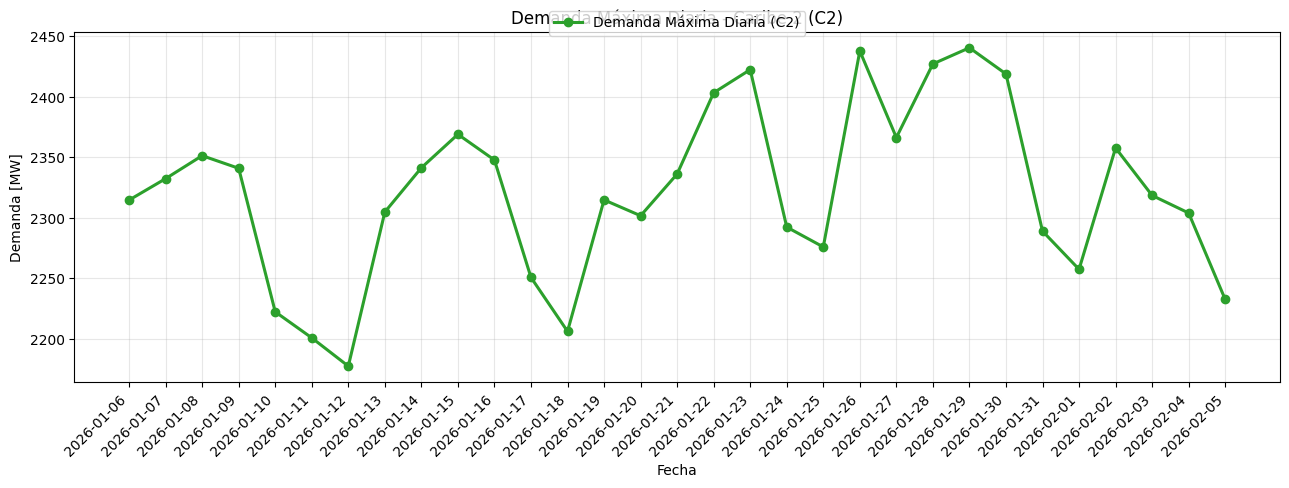

In [24]:
dataC2
# Obtener máximo diario y el periodo correspondiente
dataC2_max = (
    dataC2.loc[dataC2.groupby("fecha")["demand"].idxmax()]
    .rename(columns={"periodo": "periodo_max", "demand": "demand_max"})[["fecha", "periodo_max", "demand_max"]]
    .reset_index(drop=True)
)

# Gráfica de dataC2
df_plot = dataC2_max.copy()
df_plot["fecha"] = pd.to_datetime(df_plot["fecha"])
df_plot = df_plot.sort_values("fecha")

plt.figure(figsize=(13, 5))
plt.plot(
    df_plot["fecha"], 
    df_plot["demand_max"],
    linewidth=2.2,
    color="tab:green",
    marker="o",
    markersize=6,
    label="Demanda Máxima Diaria (C2)"
)

plt.ylabel("Demanda [MW]")
plt.xlabel("Fecha")
plt.title("Demanda Máxima Diaria - Caribe 2 (C2)")
plt.xticks(df_plot["fecha"], df_plot["fecha"].dt.strftime("%Y-%m-%d"), rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.08))
plt.tight_layout()
plt.show()

In [25]:
df_final=df_DemReal_max.merge(data_max,left_on=['Date'],right_on=['fecha'], how='inner')[['Date','Dem_max','demand_max']]
# df_final=df_final.merge(data_max,left_on=['Date'],right_on=['fecha'], how='inner')[['Date','HI_mean_C','Dem_max','demand_max']]
df_final=df_final.merge(df_DemRealSINDia,left_on=['Date'],right_on=['Date'], how='inner')[['Date','Dem_max','demand_max','Dem']]
df_final=df_final.merge(dataSIN,left_on=['Date'],right_on=['fecha'], how='inner')[['Date','Dem_max','demand_max','Dem','demand']]

In [26]:
df_final=df_final.rename(columns={'HI_mean_C':'Heat Index','Dem_max':'Dem_Real Car','demand_max':'Dem_Pron Car','Dem':'Dem_Real SIN','demand':'Dem_Pron SIN'})
df_final['Error Car %']=(100*((df_final['Dem_Pron Car']-df_final['Dem_Real Car'])/df_final['Dem_Real Car'])).round(1)
df_final['Error SIN %']=(100*((df_final['Dem_Pron SIN']-df_final['Dem_Real SIN'])/df_final['Dem_Real SIN'])).round(1)


In [27]:
df_final

,Date,Dem_Real Car,Dem_Pron Car,Dem_Real SIN,Dem_Pron SIN,Error Car %,Error SIN %
0,2026-01-06,3043.59,3247.50,227.88,230.60,6.7,1.2
1,2026-01-07,3060.41,3265.99,230.57,231.05,6.7,0.2
2,2026-01-08,3149.54,3259.58,233.53,232.07,3.5,-0.6
3,2026-01-09,3137.21,3232.60,235.97,231.46,3.0,-1.9
4,2026-01-10,3032.29,3113.27,225.49,222.60,2.7,-1.3
5,2026-01-11,2953.05,3073.63,207.68,205.35,4.1,-1.1
6,2026-01-12,2952.17,3037.92,210.02,207.71,2.9,-1.1
7,2026-01-13,3007.61,3206.08,231.11,231.03,6.6,-0.0
8,2026-01-14,3061.11,3263.67,235.61,234.71,6.6,-0.4
9,2026-01-15,3116.73,3284.44,238.63,234.24,5.4,-1.8


In [28]:
# Eliminar filas con Error % > 100
df_finalCar=df_final.copy()
df_finalCar = df_finalCar[df_finalCar['Error Car %'] <= 100].reset_index(drop=True)

df_finalSIN=df_final.copy()
df_finalSIN = df_finalSIN[df_finalSIN['Error SIN %'] <= 100].reset_index(drop=True)

df_finalCar

,Date,Dem_Real Car,Dem_Pron Car,Dem_Real SIN,Dem_Pron SIN,Error Car %,Error SIN %
0,2026-01-06,3043.59,3247.50,227.88,230.60,6.7,1.2
1,2026-01-07,3060.41,3265.99,230.57,231.05,6.7,0.2
2,2026-01-08,3149.54,3259.58,233.53,232.07,3.5,-0.6
3,2026-01-09,3137.21,3232.60,235.97,231.46,3.0,-1.9
4,2026-01-10,3032.29,3113.27,225.49,222.60,2.7,-1.3
5,2026-01-11,2953.05,3073.63,207.68,205.35,4.1,-1.1
6,2026-01-12,2952.17,3037.92,210.02,207.71,2.9,-1.1
7,2026-01-13,3007.61,3206.08,231.11,231.03,6.6,-0.0
8,2026-01-14,3061.11,3263.67,235.61,234.71,6.6,-0.4
9,2026-01-15,3116.73,3284.44,238.63,234.24,5.4,-1.8


In [29]:
query = rf"""
select * from `enersinc-tbsg-bq`.tbsg.public_dsegdes
where fechaoperacion>='{sFechaIni}' and fechaoperacion <='{sFechaFin}' and nombre ='ZS_CARIBE2'
"""

# Ejecutar la consulta
df_UE = client.query(query).to_dataframe()

In [30]:
data=df_UE.copy()

for i in range(1,25):
    data = data.rename(columns={f'hora{i}': i})

data = data.melt(id_vars=['fechaoperacion', 'nombre'], 
                       value_vars=[i for i in range(1, 25)], 
                       var_name='periodo', 
                       value_name='UE')

data['fechaoperacion'] = pd.to_datetime(data['fechaoperacion']).dt.date

# Obtener máximo diario y el periodo correspondiente
data_max_UE = (
    data.loc[data.groupby("fechaoperacion")["UE"].idxmax()]
    .rename(columns={"periodo": "periodo_max", "UE": "UE_max"})[["fechaoperacion", "periodo_max", "UE_max"]]
    .reset_index(drop=True)
)



df_finalCar=df_finalCar.merge(data_max_UE,left_on=['Date'],right_on=['fechaoperacion'], how='inner')[['Date','Dem_Real Car','Dem_Pron Car','Error Car %','UE_max']]
df_finalCar

,Date,Dem_Real Car,Dem_Pron Car,Error Car %,UE_max
0,2026-01-06,3043.59,3247.50,6.7,7.0
1,2026-01-07,3060.41,3265.99,6.7,7.0
2,2026-01-08,3149.54,3259.58,3.5,8.5
3,2026-01-09,3137.21,3232.60,3.0,8.5
4,2026-01-10,3032.29,3113.27,2.7,6.5
5,2026-01-11,2953.05,3073.63,4.1,6.5
6,2026-01-12,2952.17,3037.92,2.9,6.5
7,2026-01-13,3007.61,3206.08,6.6,7.0
8,2026-01-14,3061.11,3263.67,6.6,8.5
9,2026-01-15,3116.73,3284.44,5.4,8.5


### Gráfica de Caribe

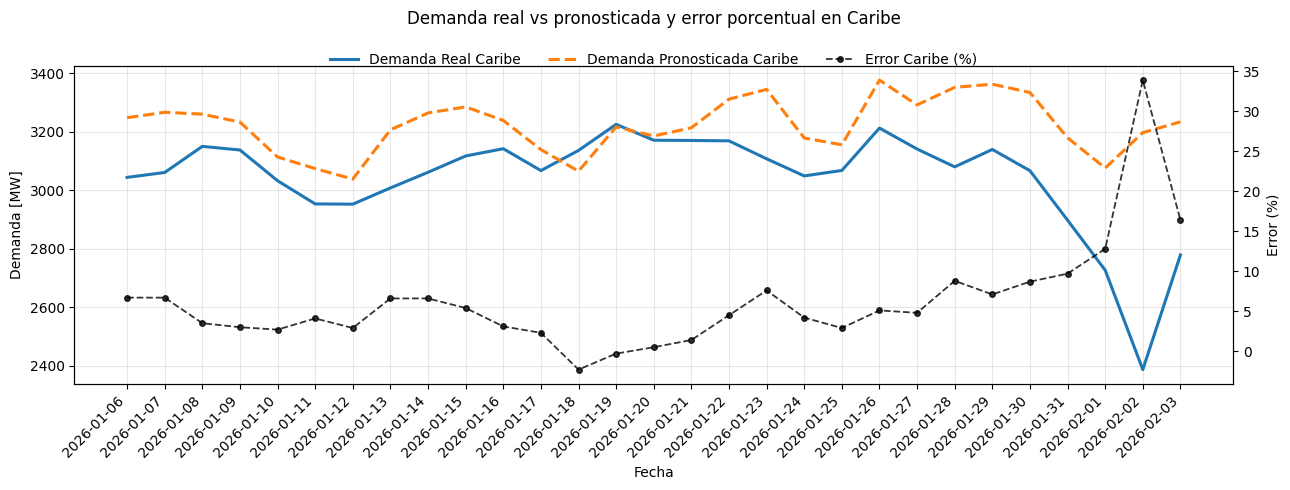

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_finalCar.copy()

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

fig, ax1 = plt.subplots(figsize=(13,5))

# -----------------------
# Eje izquierdo: Demanda
# -----------------------
ax1.plot(
    df["Date"], df["Dem_Real Car"],
    label="Demanda Real Caribe",
    linewidth=2.2,
    color="tab:blue"
)

ax1.plot(
    df["Date"], df["Dem_Pron Car"],
    label="Demanda Pronosticada Caribe",
    linestyle="--",
    linewidth=2.2,
    color="tab:orange"
)

ax1.set_ylabel("Demanda [MW]")
ax1.set_xlabel("Fecha")
ax1.grid(True, alpha=0.3)

# -----------------------
# Eje derecho: Error %
# -----------------------
ax2 = ax1.twinx()
ax2.plot(
    df["Date"], df["Error Car %"],
    label="Error Caribe (%)",
    linestyle="--",
    linewidth=1.3,
    color="black",
    marker="o",
    markersize=4,
    alpha=0.8
)
ax2.set_ylabel("Error (%)")
ax2.tick_params(axis="y")

# -----------------------
# Eje X: fechas ordenadas
# -----------------------
ax1.set_xticks(df["Date"])
ax1.set_xticklabels(
    df["Date"].dt.strftime("%Y-%m-%d"),
    rotation=45,
    ha="right"
)

# -----------------------
# Título
# -----------------------
ax1.set_title(
    "Demanda real vs pronosticada y error porcentual en Caribe",
    pad=30   # espacio entre título y leyenda
)

# -----------------------
# LEYENDA ENTRE TÍTULO Y GRÁFICA (CLAVE)
# -----------------------
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.08),
    ncol=3,
    frameon=False
)

# -----------------------
# Ajuste fino del layout
# -----------------------
plt.tight_layout()
plt.show()




### Gráfica del SIN

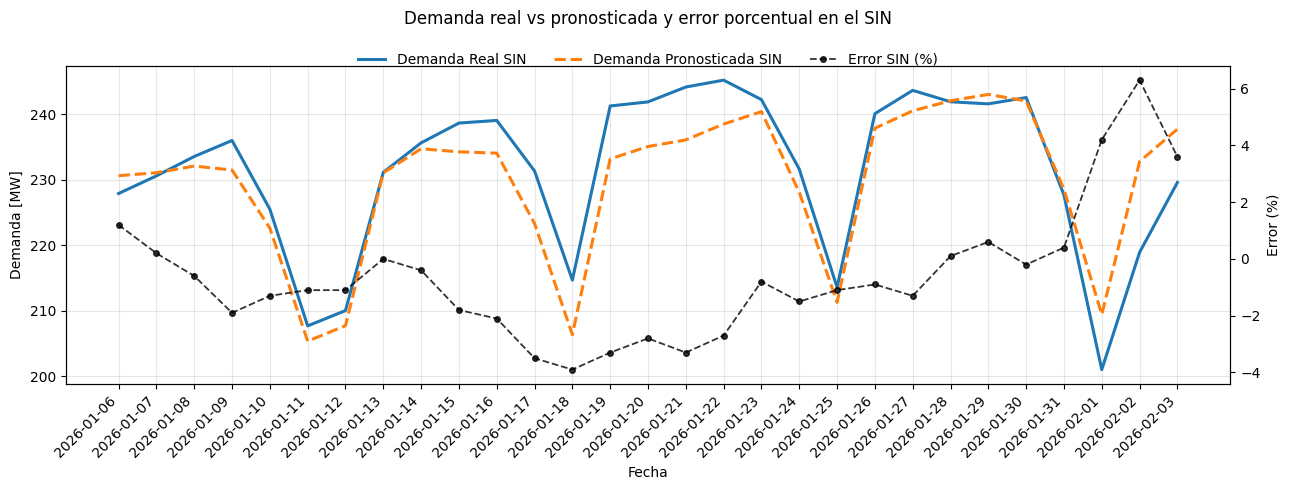

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = df_finalSIN.copy()

df1["Date"] = pd.to_datetime(df1["Date"])
df1 = df1.sort_values("Date")

fig, ax1 = plt.subplots(figsize=(13,5))

# -----------------------
# Eje izquierdo: Demanda
# -----------------------
ax1.plot(
    df1["Date"], df1["Dem_Real SIN"],
    label="Demanda Real SIN",
    linewidth=2.2,
    color="tab:blue"
)

ax1.plot(
    df1["Date"], df1["Dem_Pron SIN"],
    label="Demanda Pronosticada SIN",
    linestyle="--",
    linewidth=2.2,
    color="tab:orange"
)

ax1.set_ylabel("Demanda [MW]")
ax1.set_xlabel("Fecha")
ax1.grid(True, alpha=0.3)

# -----------------------
# Eje derecho: Error %
# -----------------------
ax2 = ax1.twinx()
ax2.plot(
    df1["Date"], df1["Error SIN %"],
    label="Error SIN (%)",
    linestyle="--",
    linewidth=1.3,
    color="black",
    marker="o",
    markersize=4,
    alpha=0.8
)
ax2.set_ylabel("Error (%)")
ax2.tick_params(axis="y")

# -----------------------
# Eje X: fechas ordenadas
# -----------------------
ax1.set_xticks(df1["Date"])
ax1.set_xticklabels(
    df1["Date"].dt.strftime("%Y-%m-%d"),
    rotation=45,
    ha="right"
)

# -----------------------
# Título
# -----------------------
ax1.set_title(
    "Demanda real vs pronosticada y error porcentual en el SIN",
    pad=30   # espacio entre título y leyenda
)

# -----------------------
# LEYENDA ENTRE TÍTULO Y GRÁFICA (CLAVE)
# -----------------------
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.08),
    ncol=3,
    frameon=False
)

# -----------------------
# Ajuste fino del layout
# -----------------------
plt.tight_layout()
plt.show()

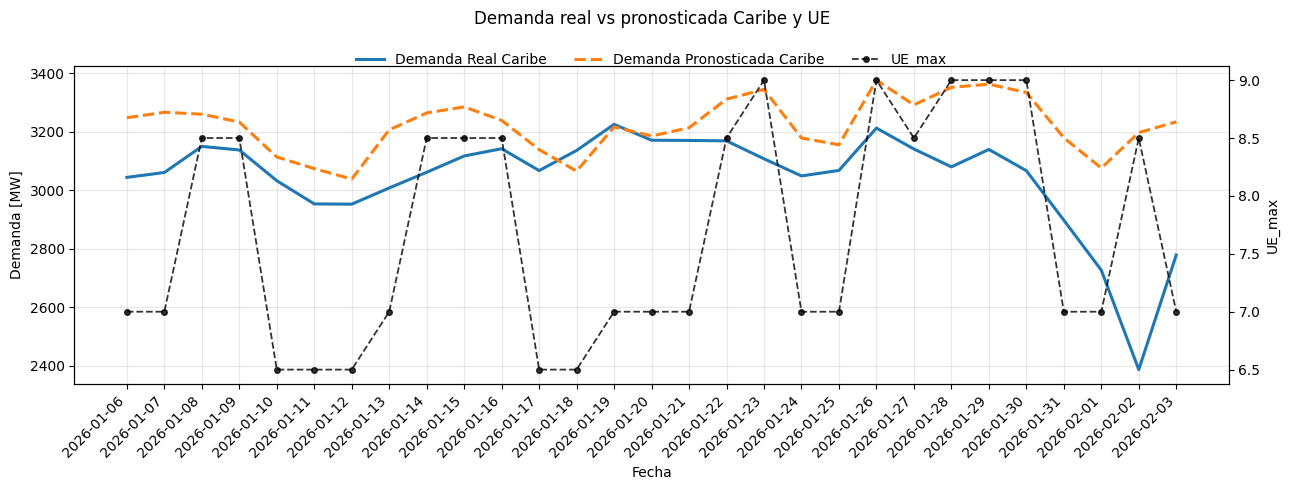

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_finalCar.copy()

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

fig, ax1 = plt.subplots(figsize=(13,5))

# -----------------------
# Eje izquierdo: Demanda
# -----------------------
ax1.plot(
    df["Date"], df["Dem_Real Car"],
    label="Demanda Real Caribe",
    linewidth=2.2,
    color="tab:blue"
)

ax1.plot(
    df["Date"], df["Dem_Pron Car"],
    label="Demanda Pronosticada Caribe",
    linestyle="--",
    linewidth=2.2,
    color="tab:orange"
)

ax1.set_ylabel("Demanda [MW]")
ax1.set_xlabel("Fecha")
ax1.grid(True, alpha=0.3)

# -----------------------
# Eje derecho: Error %
# -----------------------
ax2 = ax1.twinx()
ax2.plot(
    df["Date"], df["UE_max"],
    label="UE_max",
    linestyle="--",
    linewidth=1.3,
    color="black",
    marker="o",
    markersize=4,
    alpha=0.8
)
ax2.set_ylabel("UE_max")
ax2.tick_params(axis="y")

# -----------------------
# Eje X: fechas ordenadas
# -----------------------
ax1.set_xticks(df["Date"])
ax1.set_xticklabels(
    df["Date"].dt.strftime("%Y-%m-%d"),
    rotation=45,
    ha="right"
)

# -----------------------
# Título
# -----------------------
ax1.set_title(
    "Demanda real vs pronosticada Caribe y UE",
    pad=30   # espacio entre título y leyenda
)

# -----------------------
# LEYENDA ENTRE TÍTULO Y GRÁFICA (CLAVE)
# -----------------------
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.08),
    ncol=3,
    frameon=False
)

# -----------------------
# Ajuste fino del layout
# -----------------------
plt.tight_layout()
plt.show()

In [34]:
df_final=df_d.merge(df_DemReal_max,left_on=['datetime'],right_on=['Date'], how='inner')[['Date','HI_mean_C','Dem_max']]
df_final=df_final.merge(data_max,left_on=['Date'],right_on=['fecha'], how='inner')[['Date','HI_mean_C','Dem_max','demand_max']]
df_final=df_final.merge(df_DemRealSINDia,left_on=['Date'],right_on=['Date'], how='inner')[['Date','HI_mean_C','Dem_max','demand_max','Dem']]
df_final=df_final.merge(dataSIN,left_on=['Date'],right_on=['fecha'], how='inner')[['Date','HI_mean_C','Dem_max','demand_max','Dem','demand']]

df_final=df_final.rename(columns={'HI_mean_C':'Heat Index','Dem_max':'Dem_Real Car','demand_max':'Dem_Pron Car','Dem':'Dem_Real SIN','demand':'Dem_Pron SIN'})
df_final['Error Car %']=(100*((df_final['Dem_Pron Car']-df_final['Dem_Real Car'])/df_final['Dem_Real Car'])).round(1)
df_final['Error SIN %']=(100*((df_final['Dem_Pron SIN']-df_final['Dem_Real SIN'])/df_final['Dem_Real SIN'])).round(1)

In [35]:
df_final

,Date,Heat Index,Dem_Real Car,Dem_Pron Car,Dem_Real SIN,Dem_Pron SIN,Error Car %,Error SIN %
0,2026-01-06,26.531555,3043.59,3247.5,227.88,230.6,6.7,1.2


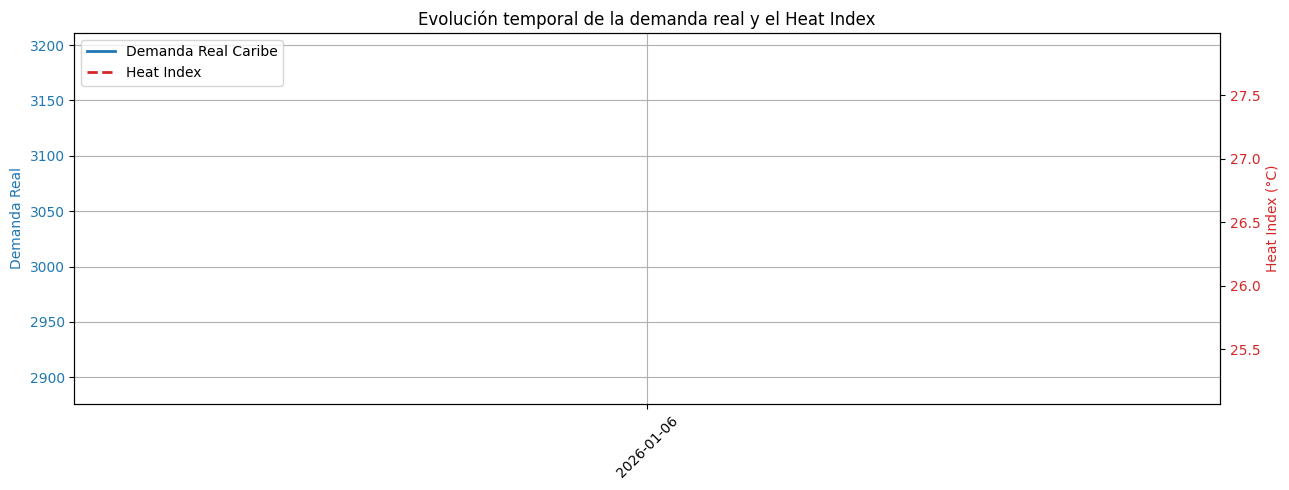

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_final.copy()
# Asegurar datetime y orden
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

fig, ax1 = plt.subplots(figsize=(13,5))

# Demanda (eje izquierdo)
ax1.plot(
    df["Date"],
    df["Dem_Real Car"],
    color="tab:blue",
    linewidth=2,
    label="Demanda Real Caribe"
)
ax1.set_ylabel("Demanda Real", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True)

# Heat Index (eje derecho)
ax2 = ax1.twinx()
ax2.plot(
    df["Date"],
    df["Heat Index"],
    color="tab:red",
    linestyle="--",
    linewidth=2,
    label="Heat Index"
)
ax2.set_ylabel("Heat Index (°C)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# 🔹 CLAVE: usar las fechas como categorías ordenadas
ax1.set_xticks(df["Date"])
ax1.set_xticklabels(df["Date"].dt.strftime("%Y-%m-%d"), rotation=45)

# Leyenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Evolución temporal de la demanda real y el Heat Index")
plt.tight_layout()
plt.show()


